## Problem statement

$$ \frac{\partial }{\partial x*} \left(  ( 1 + \epsilon_c \theta )  \frac{\partial \theta }{\partial x*} \right)   - N^2 \theta + N^2 G ( 1 + \epsilon_G \theta ) = 0   $$ 

#### Where: 

- $\theta(x) = \dfrac{T(x) - T_{inf}}{T_{b} - T_{{inf}}}$


- $N = \sqrt{\dfrac{h P L^2}{ k_0 A }} $


- $G=\dfrac{q_0A}{hP(T_b-T_{inf})}$


- $\epsilon_G=\epsilon(T_b-T_{inf})$


- $\epsilon_C=\beta(T_b-T_{inf})$

#### and the boundary conditions are:

- at $x^* = 0 \rightarrow \theta = 1$

- at $x^* = 1 \rightarrow \dfrac{d\theta}{dx^*} = 0$


**Given a sample which contains 9 values of $x$ and $\theta$ predict $G$** 

In [53]:
eg = .6
ec = .4
N = 1

## Import libraries 

In [54]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import pandas as pd
import matplotlib.pyplot as plt


import numpy as np
import time

## Hyper-parameters

In [55]:
seed_id = 1234
steps = 30000
lr = 4e-3
nneurons = 20
nhiden_layers = 8
N_f = 50 #Total number of collocation points 
offset = .0001
G_init = 1.
print("Our guess o G is :", G_init)
device = 'cpu'

Our guess o G is : 1.0


### Set random seed and select device

In [56]:
#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(seed_id)

# Random number generators in other libraries
np.random.seed(seed_id)

## Load data

In [57]:
relative_csv_path = "./../data/raw/heat_transfer_finn.csv"

# Load a random sample
fields_G = ['G']
fields_T = ['T1', 'T2', 'T3', 'T4' ,'T5', 'T6' ,'T7', 'T8' ,'T9']
fields = fields_T + fields_G
df_T = pd.read_csv(relative_csv_path, skipinitialspace=True, usecols=fields)
random_sample = df_T.sample()
print('The data used is form the sample:',random_sample.index[0])
G_real = random_sample[fields_G].to_numpy()
T_real = random_sample[fields_T].to_numpy().T
X_real = np.linspace(0,1,T_real.shape[0]).reshape(-1,1)
X_real = X_real.astype(np.float32)
X_bc = X_real[-1].reshape(-1,1)

# compute theta 
T_inf = 27 + 273 #in K
T_b = 127 + 273 #in K
Theta_real = np.multiply(np.add(T_real, [-T_inf]), [1/(T_b - T_inf)])
Theta_real = Theta_real.astype(np.float32)
Theta_real = torch.from_numpy(Theta_real)
print('G_real is:',G_real)

# lower and uper bounds to normalize the input of net U
lb = min(X_real)
ub = max(X_real)

The data used is form the sample: 67
G_real is: [[0.70303543]]


### Collocation points ($loss_f$) and auxiliary loss vectors

In [58]:
# colocation points to evaluate PDE loss
f_hat = torch.zeros(N_f,1).to(device)
# axuliary theta to evaluate the boundary condition loss
theta_x_hat = torch.zeros(1,1).to(device)
# axuliary G to evaluate a costraint G value
lossG_hat = torch.zeros(1,1).to(device)
#
X_train_f = torch.linspace(lb[0] + offset,ub[0] - offset,N_f).reshape(-1,1)
print("The number of collocation points are", N_f)

The number of collocation points are 50


## Define architecture 

In [59]:
input_dim = X_real.shape[1]
output_dim = Theta_real.shape[1]
layers = np.array([input_dim] + [ nneurons for i in range(nhiden_layers)] + [output_dim])
print("The number of layers selected are", layers.size-1)

The number of layers selected are 9


## Deep NN class

In [60]:
#  Deep Neural Network
class DNN(nn.Module):
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
    
        'Initialize neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
    
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
    'foward pass'
    def forward(self,x):
              
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
            
        #convert to float
        a = x.float()

        # inpunt and hidden layers forward computation
        for i in range(len(layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)

        # output layer forward computation            
        a = self.linears[-1](a)
        
        return a

## PINN class

In [61]:
class PINN():
    def __init__(self, layers):
        
        'Define loss function'
        self.loss_function = nn.MSELoss(reduction ='sum')
        
        'Initialize iterator'
        self.iter = 0
        
        'Initialize our new parameter G, N, ec, eg as tensor (Inverse problem)' 
        self.G = torch.tensor([float(G_init)], requires_grad=True).float().to(device)  
                
        'Register parametes to be optimized'
        self.G = nn.Parameter(self.G)

        'Initialize our DNN'
        self.dnn = DNN(layers).to(device)
        
        'Register our new parameter'
        self.dnn.register_parameter('G', self.G)  

        'History of losses'
        self.loss_history = {"Data": [],
                             "PDE": [],
                             "BC": [],
                             "G": [],
                             "Total":[]}
        
        'Parameters trials'
        self.params_history = {"G": [] }

    def loss_data(self, x, theta_real, save = False):
                   
        if torch.is_tensor(theta_real) != True:         
            theta_real = torch.from_numpy(theta_real)
        
        theta_nn = self.dnn(x)
        loss_d = self.loss_function(theta_nn, theta_real)
        
        save and self.loss_history["Data"].append(loss_d.to('cpu').detach().numpy()) 
        
        return loss_d
        
    def loss_PDE(self, x_f, save = False):
                       
        # extract the PDE parameters
        G = self.G

        # clone the input data and add AD
        x = x_f.clone()
        x.requires_grad = True
        
        # predict theta
        theta = self.dnn(x)
        
        # compute derivatives 
        theta_x = autograd.grad(theta, x, torch.ones([x_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        
        # copmute term to be derived
        aux = (1 + ec * theta) * theta_x

        aux_x = autograd.grad(aux, x, torch.ones(x_f.shape).to(device), create_graph=True)[0]
        
        # PDE f  = 0
        f = aux_x - N**2*theta + N**2*G*(1 + eg*theta)   

        # f_hat is just an auxiliar term to copmute the loss (is zero)
        loss_f = self.loss_function(f, f_hat)
        
        save and self.loss_history["PDE"].append(loss_f.to('cpu').detach().numpy()) 

        return loss_f
    
    def loss_BC(self,x_bc, save = False):
        
        if torch.is_tensor(x_bc) != True:         
            x_bc = torch.from_numpy(x_bc)

        # clone the input data and add AD
        x = x_bc.clone()
        x.requires_grad = True
        
        # predict theta
        theta = self.dnn(x)
        
        # compute derivatives 
        theta_x = autograd.grad(theta, x, torch.ones([x_bc.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        
        loss_bc = self.loss_function(theta_x, theta_x_hat)
        
        save and self.loss_history["BC"].append(loss_bc.to('cpu').detach().numpy()) 

        return loss_bc
    
    def loss_G(self, save = False):
        lossG = 0.0
        G_NN = self.G
        if G_NN < 1e-5:
            K = 1000
            lossG = K * G_NN**2

        lossG = self.loss_function(torch.Tensor([lossG]), lossG_hat)
            

        save and self.loss_history["G"].append(lossG)
                
        return lossG
        
    def loss(self, x_real, theta_real, x_f, x_bc, save = False):

        loss_d  = self.loss_data(x_real, theta_real, save)
        loss_f  = self.loss_PDE(x_f, save)
        loss_bc = self.loss_BC(x_bc, save)
        loss_g = self.loss_G(save)
        
        # weights should sum 1
        loss_val = loss_d + loss_f + loss_bc + loss_g

        if save:
            self.loss_history["Total"].append(loss_val.to('cpu').detach().numpy())
            self.params_history["G"].append(self.G.to('cpu').data.numpy().copy())

        return loss_val
     
    'callable for optimizer'                                       
    def closure(self):
        
        optimizer.zero_grad()
        
        loss = self.loss(X_real, Theta_real, X_train_f, X_bc, True)
        
        loss.backward()
        
        self.iter += 1

        print(
            'LBFGS iter: %d, Loss error(Train): %.10f , G_real = [%.5f], G_PINN = [%.5f]' %
            (   
                self.iter,
                loss.cpu().detach().numpy(),
                G_real,
                self.G.item(),
            )
        )

        
        return loss        
    
    'foward pass'
    def forward(self,x):
        return self.dnn(x)
    
    'test neural network with the norm distance between the real and predicted theta'
    def test(self):
                
        theta_pred = self.dnn(X_real)
        # Relative L2 Norm of the error (Vector)
        error_vec = torch.linalg.norm((Theta_real - theta_pred),2)/torch.linalg.norm(Theta_real,2)  
        theta_pred = theta_pred.cpu().detach().numpy()
                        
        return error_vec, theta_pred

## Train the model with Adam


In [62]:
'Neural Network Summary'
pinn_adam = PINN(layers)

'Neural Network Parameters'
params = list(pinn_adam.dnn.parameters())

'L-BFGS Optimizer'
optimizer = torch.optim.Adam(params, lr, 
                             amsgrad = True)

# Measure time 
start_time = time.time()

'Train the model'
for epoch in range(steps):

    # compute net U prediction
    theta_nn = pinn_adam.dnn(X_real)
    loss = pinn_adam.loss(X_real, Theta_real, X_train_f, X_bc, save = True)
   
    # increment the counter 
    pinn_adam.iter +=1 

    if epoch%(steps // 100) == 0:

        print(
            'Epoch: %d, Loss error(Train): %.10f , G_real = [%.5f], G_PINN = [%.5f]' %
            (   
                pinn_adam.iter,
                loss.cpu().detach().numpy(),
                G_real,
                pinn_adam.G.item(),
            )
        )

    # update parameters
    optimizer.zero_grad()       # Zero Out the gradient
    loss.backward()    
    optimizer.step()
    
elapsed_time_adam = time.time() - start_time


Epoch: 1, Loss error(Train): 68.1632385254 , G_real = [0.70304], G_PINN = [1.00000]


/home/mvanzulli/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 301, Loss error(Train): 0.0081256162 , G_real = [0.70304], G_PINN = [0.91717]
Epoch: 601, Loss error(Train): 0.0072216438 , G_real = [0.70304], G_PINN = [0.90867]
Epoch: 901, Loss error(Train): 0.0064488752 , G_real = [0.70304], G_PINN = [0.89884]
Epoch: 1201, Loss error(Train): 0.0057219071 , G_real = [0.70304], G_PINN = [0.88853]
Epoch: 1501, Loss error(Train): 0.0050480012 , G_real = [0.70304], G_PINN = [0.87822]
Epoch: 1801, Loss error(Train): 0.0044370298 , G_real = [0.70304], G_PINN = [0.86819]
Epoch: 2101, Loss error(Train): 0.0038912604 , G_real = [0.70304], G_PINN = [0.85856]
Epoch: 2401, Loss error(Train): 0.0034082853 , G_real = [0.70304], G_PINN = [0.84941]
Epoch: 2701, Loss error(Train): 0.0029833850 , G_real = [0.70304], G_PINN = [0.84077]
Epoch: 3001, Loss error(Train): 0.0026109563 , G_real = [0.70304], G_PINN = [0.83265]
Epoch: 3301, Loss error(Train): 0.0022852202 , G_real = [0.70304], G_PINN = [0.82503]
Epoch: 3601, Loss error(Train): 0.0020007074 , G_real = [

## Train with LBFGS

In [71]:
'Neural Network Summary'
pinn_LBFGS = PINN(layers)

'Neural Network Parameters'
params = list(pinn_LBFGS.dnn.parameters())

'Mesure time'
start_time = time.time()

'L-BFGS Optimizer'
optimizer = torch.optim.LBFGS(params, lr, 
                              max_iter = steps, 
                              max_eval = None, 
                              tolerance_grad = 1e-11, 
                              tolerance_change = 1e-11, 
                              line_search_fn = 'strong_wolfe',
                              history_size = 100)

optimizer.step(pinn_LBFGS.closure)

elapsed_time_LBFGS = time.time() - start_time

LBFGS iter: 1, Loss error(Train): 63.5926055908 , G_real = [0.70304], G_PINN = [1.00000]
LBFGS iter: 2, Loss error(Train): 63.5390472412 , G_real = [0.70304], G_PINN = [0.99995]
LBFGS iter: 3, Loss error(Train): 63.0580863953 , G_real = [0.70304], G_PINN = [0.99953]
LBFGS iter: 4, Loss error(Train): 60.6791381836 , G_real = [0.70304], G_PINN = [0.99741]
LBFGS iter: 5, Loss error(Train): 37.8749198914 , G_real = [0.70304], G_PINN = [0.97406]
LBFGS iter: 6, Loss error(Train): 37.4455108643 , G_real = [0.70304], G_PINN = [0.97343]
LBFGS iter: 7, Loss error(Train): 33.6476745605 , G_real = [0.70304], G_PINN = [0.96775]
LBFGS iter: 8, Loss error(Train): 5.5797348022 , G_real = [0.70304], G_PINN = [0.91099]
LBFGS iter: 9, Loss error(Train): 5.5001807213 , G_real = [0.70304], G_PINN = [0.91072]
LBFGS iter: 10, Loss error(Train): 4.8057627678 , G_real = [0.70304], G_PINN = [0.90829]
LBFGS iter: 11, Loss error(Train): 0.4576961696 , G_real = [0.70304], G_PINN = [0.88402]
LBFGS iter: 12, Loss er

## Elapsed time

In [72]:
print("Elapsed time with LBFGS is:", elapsed_time_LBFGS)
print("Elapsed time with Adam is:", elapsed_time_adam)

Elapsed time with LBFGS is: 1.5260815620422363
Elapsed time with Adam is: 161.03314208984375


# Losses plot vs num epochs (ADAM + LBFGS)

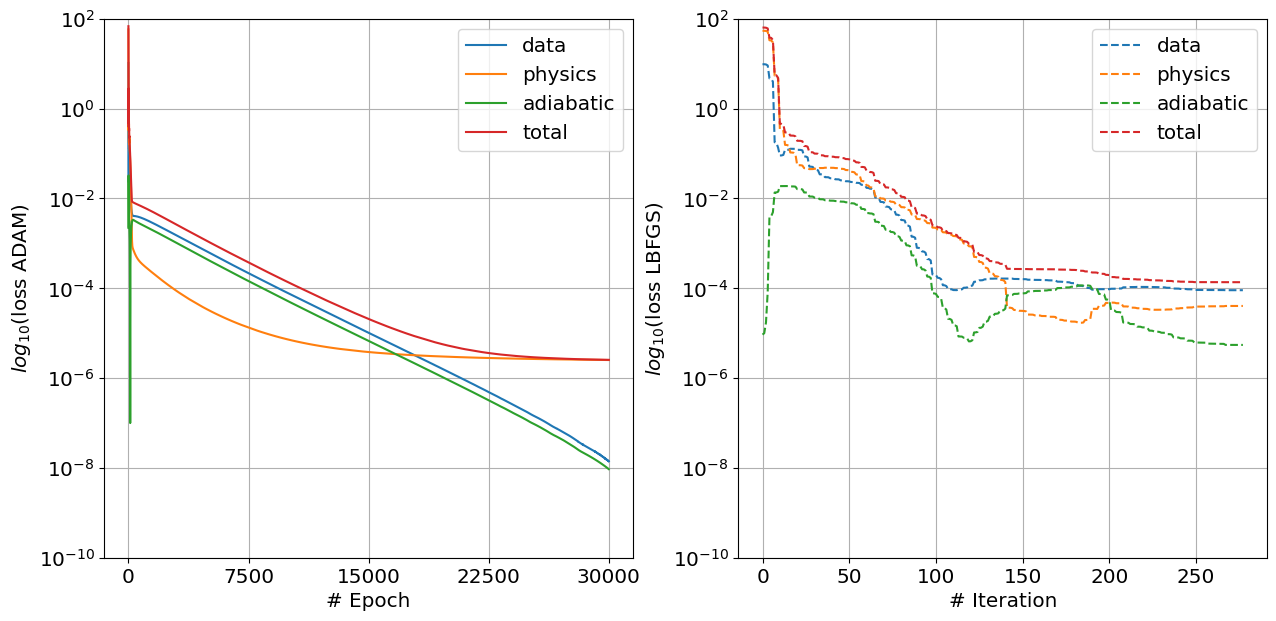

In [73]:
def plot_pinns_losses(pinn_1, pinn_2, path_fig, label_size = 8):

    ylim = (1e-10, 1e2)
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))

    # Pin 1 loss evolution
    ax[0].cla()
    ax[0].plot(pinn_1.loss_history["Data"] , label = 'data')
    ax[0].plot(pinn_1.loss_history["PDE"] , label = 'physics')
    ax[0].plot(pinn_1.loss_history["BC"] , label = 'adiabatic')
    ax[0].plot(pinn_1.loss_history["Total"] , label = 'total')
    ax[0].set_xticks(np.arange(0, len(pinn_1.loss_history["Total"])+1, 7500))
    ax[0].set_xlabel('# Epoch', fontsize = 1.8*label_size)
    ax[0].set_ylabel(r'$log_{10}$(loss ADAM)', fontsize = 1.8*label_size)
    ax[0].set_yscale('log')
    ax[0].legend(loc='upper right', fontsize = 1.8*label_size)
    ax[0].grid(True, which="both", ls="-")
    ax[0].tick_params(axis='both', which='major', labelsize=1.8*label_size)
    ax[0].set_ylim(ylim)
    
    # Pin 2 loss evolution
    ax[1].cla()
    ax[1].plot(pinn_2.loss_history["Data"] , label = 'data', linestyle = '--')
    ax[1].plot(pinn_2.loss_history["PDE"] , label = 'physics', linestyle = '--')
    ax[1].plot(pinn_2.loss_history["BC"] , label = 'adiabatic', linestyle = '--')
    ax[1].plot(pinn_2.loss_history["Total"] , label = 'total', linestyle = '--')
    ax[1].set_xlabel('# Iteration', fontsize = 1.8*label_size)
    ax[1].set_ylabel(r'$log_{10}$(loss LBFGS)', fontsize = 1.8*label_size)
    ax[1].set_yscale('log')
    ax[1].legend(loc='upper right', fontsize = 1.8*label_size)
    ax[1].grid(True, which="both", ls="-")
    ax[1].tick_params(axis='both', which='major', labelsize=1.8*label_size)
    ax[1].set_ylim(ylim)

    fig.savefig(path_fig, bbox_inches='tight')


path_fig = './../../figures/PINN/loss_vs_epoch_vanilla.png'
plot_pinns_losses(pinn_adam, pinn_LBFGS, path_fig)





## Plots Vanilla PINN

### PINN G predicted value vs num epochs

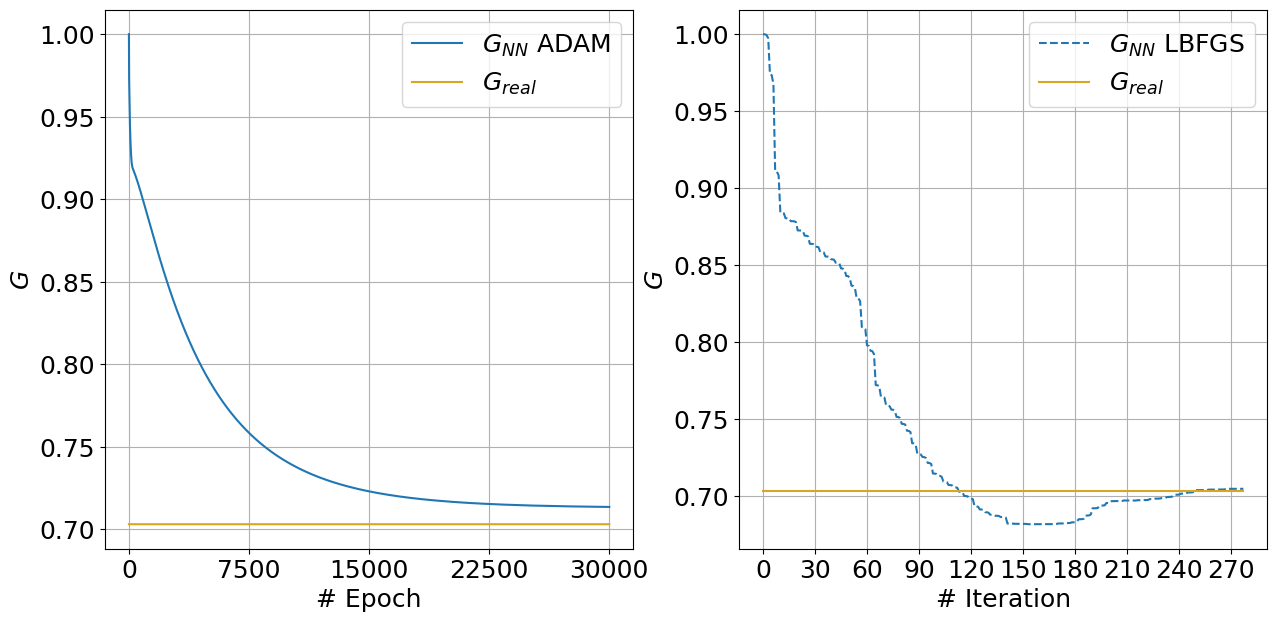

In [74]:
label_size = 10

fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# G evolution with ADAM 
nsteps_adam = len(pinn_adam.params_history["G"])
ax[0].cla()
ax[0].plot(pinn_adam.params_history["G"], label = r'$G_{NN}$ ADAM')
ax[0].set_xlabel('# Epoch', fontsize = 1.8*label_size)
ax[0].set_ylabel(r'$G$', fontsize = 1.8*label_size)
ax[0].plot(range(nsteps_adam), G_real*np.ones((nsteps_adam,1)), label = r'$G_{real}$', color = 'goldenrod')
ax[0].grid(True, which="both", ls="-")
ax[0].tick_params(axis='both', which='major', labelsize=1.8*label_size)
ax[0].legend(loc='upper right', fontsize = 1.8*label_size)
ax[0].set_xticks(np.arange(0, len(pinn_adam.params_history["G"])+1, 7500))

# G evolution with LBFGS 
nsteps_lbfgs = len(pinn_LBFGS.params_history["G"])
ax[1].cla()
ax[1].plot(pinn_LBFGS.params_history["G"], linestyle = '--', label = r'$G_{NN}$ LBFGS')
ax[1].set_xlabel('# Iteration', fontsize = 1.8*label_size)
ax[1].set_xticks(np.arange(0, nsteps_lbfgs, 30))
ax[1].set_ylabel(r'$G$', fontsize = 1.8*label_size)
ax[1].plot(range(nsteps_lbfgs), G_real*np.ones((nsteps_lbfgs,1)), label = r'$G_{real}$', color = 'goldenrod')
ax[1].grid(True, which="both", ls="-")
ax[1].tick_params(axis='both', which='major', labelsize=1.8*label_size)
ax[1].legend(loc='upper right', fontsize = 1.8*label_size)



path_fig = './../../figures/PINN/evolution_G_vanilla.png'
fig.savefig(path_fig, bbox_inches='tight')


###  Plot $\theta(x)$ solution

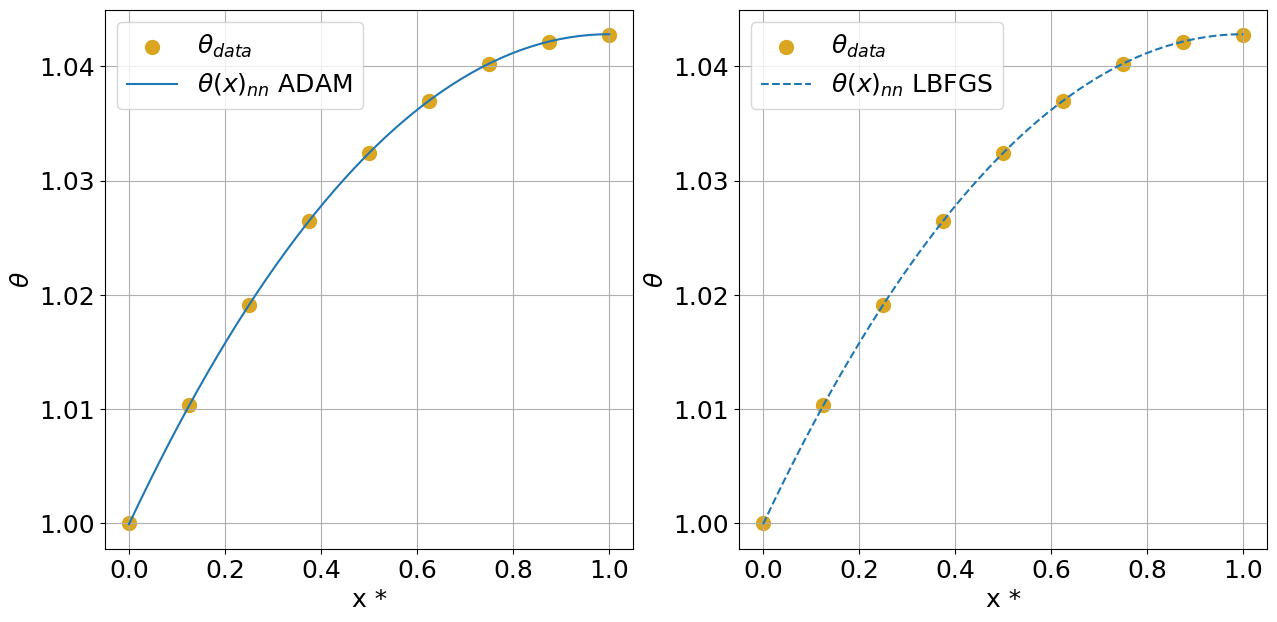

In [67]:
# Compute theta real values
x_u = X_real
theta_real = Theta_real.to('cpu').detach().numpy()

# Compute theta predicted by the PINN with Adam
x_f = X_train_f.to('cpu').detach().numpy()
theta_nn_adam = pinn_adam.forward(X_train_f).to('cpu').detach().numpy()
theta_nn_lbfgs = pinn_adam.forward(X_train_f).to('cpu').detach().numpy()


# Plot both figures
label_size = 10

fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# theta(x) predicted vs real with ADAM 
ax[0].cla()
ax[0].scatter(x_u, theta_real, color = 'goldenrod', label = r'$\theta_{data}$', s = 100)
ax[0].plot(x_f, theta_nn_adam, label = r'$\theta(x)_{nn}$ ADAM')
ax[0].set_xlabel(r'x *', fontsize = 1.8*label_size)
ax[0].set_ylabel(r'$\theta$', fontsize = 1.8*label_size)
ax[0].grid(True, which="both", ls="-")
ax[0].tick_params(axis='both', which='major', labelsize=1.8*label_size)
ax[0].legend(loc='best', fontsize = 1.8*label_size)

# theta(x) predicted vs real with LBFGS 
ax[1].cla()
ax[1].scatter(x_u, theta_real, color = 'goldenrod', label = r'$\theta_{data}$', s = 100)
ax[1].plot(x_f, theta_nn_lbfgs, label = r'$\theta(x)_{nn} $ LBFGS', linestyle = '--')
ax[1].set_xlabel(r'x *', fontsize = 1.8*label_size)
ax[1].set_ylabel(r'$\theta$', fontsize = 1.8*label_size)
ax[1].grid(True, which="both", ls="-")
ax[1].tick_params(axis='both', which='major', labelsize=1.8*label_size)
ax[1].legend(loc='best', fontsize = 1.8*label_size)

path_fig = './../../figures/PINN/theta_vs_x_vanilla.png'
fig.savefig(path_fig, bbox_inches='tight')


## Add standarad deviation noise to the data 

In [75]:
std_dev = 1e-2*np.array([5, 10, 20])

deviation_T =  T_real.std()

losses_to_plot = []
theta_nn_to_plot = []
G_to_plot= []


for deviation in std_dev:

    # Add noise to the data
    T_real_noisy = torch.from_numpy(T_real) 
    noise_T = torch.normal(0, deviation*deviation_T, T_real.shape)
    T_real_noisy += noise_T
    Theta_noisy = torch.multiply(torch.add(T_real_noisy, torch.tensor([-T_inf])), torch.tensor([1/(T_b - T_inf)]))

    # Hardcode the dirichlet bc value 
    Theta_noisy[0] = 1.0
    Theta_noisy = Theta_noisy.type(torch.Tensor)
    # to use the optimizer calable method 
    Theta_real = Theta_noisy


    'Neural Network Summary'
    pinn_noisy = PINN(layers)

    'Neural Network Parameters'
    params_noisy = list(pinn_noisy.dnn.parameters())

    'Mesure time'
    start_time = time.time()


    'L-BFGS Optimizer'
    optimizer = torch.optim.LBFGS(params_noisy, lr, 
                                max_iter = steps, 
                                max_eval = None, 
                                tolerance_grad = 1e-11, 
                                tolerance_change = 1e-11, 
                                line_search_fn = 'strong_wolfe',
                                history_size = 100)

    optimizer.step(pinn_noisy.closure)

    'Save losses, G_hist and theta prediction'
    losses_to_plot.append(pinn_noisy.loss_history["Total"].copy())
    theta_nn_to_plot.append(pinn_noisy.forward(X_train_f).to('cpu').detach().numpy())
    G_to_plot.append(pinn_noisy.params_history["G"].copy()) 

LBFGS iter: 1, Loss error(Train): 23.8107395172 , G_real = [0.70304], G_PINN = [1.00000]
LBFGS iter: 2, Loss error(Train): 23.7537975311 , G_real = [0.70304], G_PINN = [0.99998]
LBFGS iter: 3, Loss error(Train): 23.2446060181 , G_real = [0.70304], G_PINN = [0.99980]
LBFGS iter: 4, Loss error(Train): 18.5042228699 , G_real = [0.70304], G_PINN = [0.99804]
LBFGS iter: 5, Loss error(Train): 18.3712654114 , G_real = [0.70304], G_PINN = [0.99799]
LBFGS iter: 6, Loss error(Train): 17.2015686035 , G_real = [0.70304], G_PINN = [0.99749]
LBFGS iter: 7, Loss error(Train): 8.8431921005 , G_real = [0.70304], G_PINN = [0.99252]
LBFGS iter: 8, Loss error(Train): 8.8270807266 , G_real = [0.70304], G_PINN = [0.99250]
LBFGS iter: 9, Loss error(Train): 8.6851968765 , G_real = [0.70304], G_PINN = [0.99233]
LBFGS iter: 10, Loss error(Train): 7.5796384811 , G_real = [0.70304], G_PINN = [0.99064]
LBFGS iter: 11, Loss error(Train): 7.5723280907 , G_real = [0.70304], G_PINN = [0.99062]
LBFGS iter: 12, Loss err

### Plot Vanilla PINN noise sensitivity

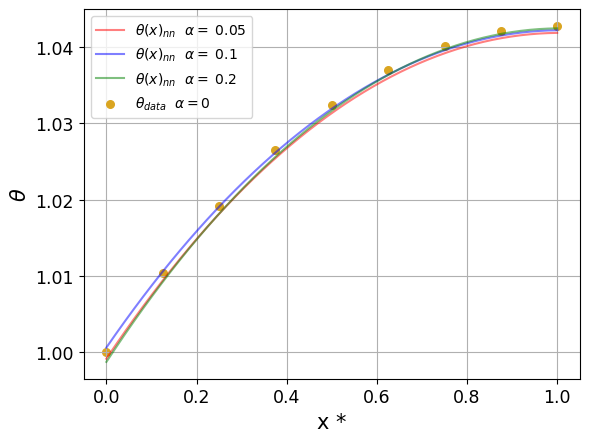

In [76]:
plt.cla()

color = ['red', 'blue', 'green']

plt.plot(x_f, theta_nn_to_plot[0], label = r'$\theta(x)_{nn}$' + ' ' + r' $\alpha = $ '+ str(std_dev[0]), color = color[0], alpha = .5)
plt.plot(x_f, theta_nn_to_plot[1], label = r'$\theta(x)_{nn}$' + ' ' + r' $\alpha = $ '+ str(std_dev[1]), color = color[1], alpha = .5)
plt.plot(x_f, theta_nn_to_plot[2], label = r'$\theta(x)_{nn}$' + ' ' + r' $\alpha = $ '+ str(std_dev[2]), color = color[2], alpha = .5)
# Plot solid scatter point 
plt.scatter(x_u, theta_real, color = 'goldenrod', label = r'$\theta_{data}$' + ' ' + r' $\alpha = 0$ ', s = 30, marker = 'o', alpha = 1)
plt.xlabel(r'x *', fontsize = 1.5*label_size)
plt.ylabel(r'$\theta$', fontsize = 1.5*label_size)
plt.grid(True, which="both", ls="-")
plt.tick_params(axis='both', which='major', labelsize=1.25*label_size)
plt.legend(loc='best', fontsize = label_size)

path_fig = './../../figures/PINN/theta_vs_x_vanilla_noise.png'
fig.savefig(path_fig, bbox_inches='tight')


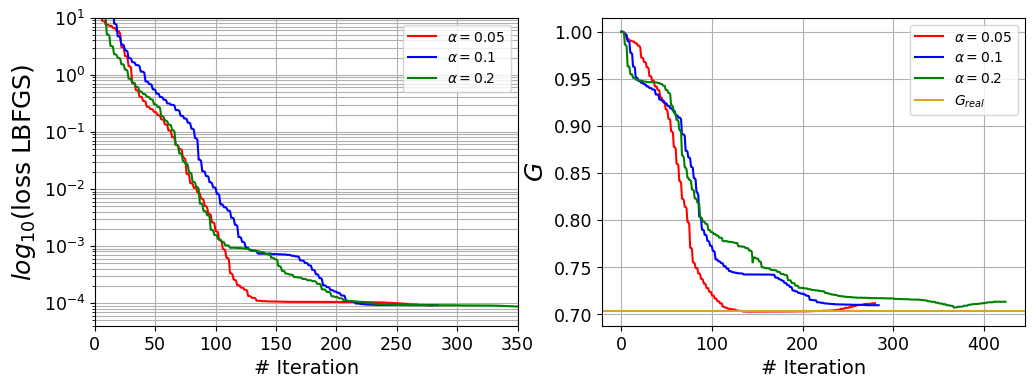

In [77]:
# Plot losses and G values 
fig,ax = plt.subplots(1, 2, figsize=(12, 4))

# plot losses 
xlim = (0, 350)
ylim =  (4e-5, 1e1)
ax[0].cla()
ax[0].plot(np.array(losses_to_plot[0]), label = r'$\alpha =$' + str(std_dev[0]), color = color[0])
ax[0].plot(np.array(losses_to_plot[1]), label = r'$\alpha =$' + str(std_dev[1]), color = color[1])
ax[0].plot(np.array(losses_to_plot[2]), label = r'$\alpha =$' + str(std_dev[2]), color = color[2])

ax[0].set_xlabel('# Iteration', fontsize = 1.4*label_size)
ax[0].set_ylabel(r'$log_{10}$(loss LBFGS)', fontsize = 1.8*label_size)
ax[0].set_yscale('log')
ax[0].legend(loc='upper right', fontsize = label_size)
ax[0].grid(True, which="both", ls="-")
ax[0].tick_params(axis='both', which='major', labelsize=1.25*label_size)
ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)


# plot G values
ax[1].cla()
ax[1].plot(np.array(G_to_plot[0]), label = r'$\alpha =$' + str(std_dev[0]), color = color[0])
ax[1].plot(np.array(G_to_plot[1]), label = r'$\alpha =$' + str(std_dev[1]), color = color[1])
ax[1].plot(np.array(G_to_plot[2]), label = r'$\alpha =$' + str(std_dev[2]), color = color[2])
ax[1].axhline(y = G_real, color = 'goldenrod', linestyle = '-',label = r'$G_{real}$')
ax[1].set_xlabel('# Iteration', fontsize = 1.4*label_size)
ax[1].set_ylabel(r'$G$', fontsize = 1.8*label_size)
ax[1].legend(loc='upper right', fontsize = label_size)
ax[1].grid(True, which="both", ls="-")
ax[1].tick_params(axis='both', which='major', labelsize=1.25*label_size)

path_fig = './../../figures/PINN/loss_vs_nepoch_vanilla_noise.png'
fig.savefig(path_fig, bbox_inches='tight')

